## General alternative implementation of transvoxel

Voxels can be used to plot the surface in space where a function `f(x,y,z)=0`.

The barmesh structure is a set of nodes, edges (each with a direction) and a link to the next clockwise edge in the polygon at both sides of each edge.  This provides a very efficient way to traverse around the network of nodes, edges and faces of a combinatorial surface.  

The key to the structure is given in the following diagram.  Note that if you change the direction of the edge, then barbackleft and barforeright still point to the same next edges, but simply change places.  Traversing is clockwise around faces, and counter-clockwise around nodes.  

```
       \barbackleft   /
        \<....       /
         \   .      /
 nodeback #-------># nodefore
         /     .    \
        /      .....>\barforeright  
       /              \

```


A polyhedron, such as a cube, is a combinatorial surface.  It is made from facets joined together.  The isosurface where `f=0` is also a combinatorial surface, which can be encoded as a barmesh, and is an efficient encoding of the triangulated surface.  I have also used these for efficient encoding of STL surfaces where I need to know the connectivity between one facet and the next.

This page is in support the following proposal: https://github.com/Zylann/godot_voxel/issues/144





In [1]:
#
# This is the barmesh structure into which we encode a polyhedron and its cuts
#
class Node:
    def __init__(self, point):
        self.point = point           # (x,y,z)
        self.intensity = 0           # <=0 inside the volume, > outside the volume

class Bar:
    def __init__(self, nodeback, nodefore):
        self.nodeback = nodeback
        self.nodefore = nodefore
        self.barforeright = None
        self.barbackleft = None
        self.midpoint = None

    def SetForeRightBL(self, bforeright, bar):
        if bforeright:
            self.barforeright = bar
        else:
            self.barbackleft = bar
        
    def SetBarFRBL(self, barforeright, barbackleft):
        self.barforeright, self.barbackleft = barforeright, barbackleft

    def GetForeRightBL(self, bforeright):
        return self.barforeright  if bforeright  else self.barbackleft
    def GetNodeFore(self, bfore):
        return self.nodefore  if bfore  else self.nodeback
    
class BarMesh:
    def __init__(self):
        self.nodes = [ ]
        self.bars = [ ]
        
    def NewNode(self, point):
        self.nodes.append(Node(point))
        return self.nodes[-1]

    def NewBar(self, nodeback, nodefore):
        self.bars.append(Bar(nodeback, nodefore))
        return self.bars[-1]
    


In [2]:
#
# This block assembles the links for the barmesh of a cube.  There is no slick way of doing it
#

def BuildCubeBarmesh(p0, p1):
    barmesh = BarMesh()
    (x0, y0, z0) = p0
    (x1, y1, z1) = p1

    # Cube has 8 vertices
    n000 = barmesh.NewNode((x0, y0, z0))
    n010 = barmesh.NewNode((x0, y1, z0))
    n100 = barmesh.NewNode((x1, y0, z0))
    n110 = barmesh.NewNode((x1, y1, z0))

    n001 = barmesh.NewNode((x0, y0, z1))
    n011 = barmesh.NewNode((x0, y1, z1))
    n101 = barmesh.NewNode((x1, y0, z1))
    n111 = barmesh.NewNode((x1, y1, z1))

    # Cube has 12 edges
    b0u0 = barmesh.NewBar(n000, n010)
    bu00 = barmesh.NewBar(n000, n100)
    b1u0 = barmesh.NewBar(n100, n110)
    bu10 = barmesh.NewBar(n010, n110)

    b00u = barmesh.NewBar(n000, n001)
    b01u = barmesh.NewBar(n010, n011)
    b10u = barmesh.NewBar(n100, n101)
    b11u = barmesh.NewBar(n110, n111)

    b0u1 = barmesh.NewBar(n001, n011)
    bu01 = barmesh.NewBar(n001, n101)
    b1u1 = barmesh.NewBar(n101, n111)
    bu11 = barmesh.NewBar(n011, n111)

    # assign the foreright and backleft links between edges
    b00u.SetBarFRBL(bu01, b0u0)
    b10u.SetBarFRBL(b1u1, bu00)
    b11u.SetBarFRBL(bu11, b1u0)
    b01u.SetBarFRBL(b0u1, bu10)

    bu00.SetBarFRBL(b1u0, b00u)
    b0u0.SetBarFRBL(b01u, bu00)
    b1u0.SetBarFRBL(bu10, b10u)
    bu10.SetBarFRBL(b11u, b0u0)

    bu01.SetBarFRBL(b10u, b0u1)
    b0u1.SetBarFRBL(bu11, b00u)
    b1u1.SetBarFRBL(b11u, bu01)
    bu11.SetBarFRBL(b1u1, b01u)

    barmesh.barrightfaces = [ b01u, b10u,  b00u, b11u,  bu00, bu11 ]  # xlo,xhi, ylo,yhi, zlo,zhi 
    return barmesh

# Used later; corresponding with barmesh.barrightfaces and barmesh.bars
transfacelookuptorightfaces = [ (-1, 0, 0), (1, 0, 0), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)]
transedgelookuptodiagonals = [ (-1, 0, -1), (0, -1, -1), (1, 0, -1), (0, 1, -1),
                               (-1, -1, 0), (-1, 1, 0), (1, -1, 0), (1, 1, 0),
                               (-1, 0, 1), (0, -1, 1), (1, 0, 1), (0, 1, 1) ]


# Verification that the above is correct
def ExtractPolyhedralface(nodefrom, bar):
    nodeseq = [ nodefrom ]
    while True:
        nodefrom, bar = bar.GetNodeFore(bar.nodeback == nodefrom), bar.GetForeRightBL(bar.nodeback == nodefrom)
        if nodefrom == nodeseq[0]:
            break
        nodeseq.append(nodefrom)
    return nodeseq


def VerifyMeshIsCube(barmesh):

    # there are 24 face from edges: 6 faces 4 times each, or 12 edges two sides each 
    from collections import Counter
    allfaceedges = [ExtractPolyhedralface(bar.nodeback, bar)  for bar in barmesh.bars] + \
                   [ExtractPolyhedralface(bar.nodefore, bar)  for bar in barmesh.bars]
    print("six 4s:", Counter(tuple(sorted(faceedge, key=lambda node: node.point))  for faceedge in allfaceedges).values())

barmesh = BuildCubeBarmesh((0,0,0), (1,1,1))
VerifyMeshIsCube(barmesh)

six 4s: dict_values([4, 4, 4, 4, 4, 4])


In [5]:
# 
# Use a intensity generator to find the cuts through a barmesh (usually a cube) 
#

def setintensities(barmesh, intensity_func):
    for node in barmesh.nodes:
        node.intensity = intensity_func(node.point[0], node.point[1], node.point[2])

def setcutpoints(barmesh):    
    def Along(lam, a0, a1):
        return a0 if lam == 0 else a1 if lam == 1 else a0*(1-lam) + a1*lam
    for bar in barmesh.bars:
        if (bar.nodeback.intensity <= 0) != (bar.nodefore.intensity <= 0):
            lam = (0 - bar.nodeback.intensity) / (bar.nodefore.intensity - bar.nodeback.intensity)
            bar.midpoint = (Along(lam, bar.nodeback.point[0], bar.nodefore.point[0]),
                            Along(lam, bar.nodeback.point[1], bar.nodefore.point[1]),
                            Along(lam, bar.nodeback.point[2], bar.nodefore.point[2]))
            
    


In [6]:
#
# The following two functions are the complete functions for traversing and extracting the faces 
# of the isosurface f=0 where it cuts through the volume contained by the barmesh
# !!!This is the programatic equivalent of those transvoxel lookup tables
#

def ExtractCutPolyhedralfaceLeft(bar):
    assert (bar.nodeback.intensity <= 0) != (bar.nodefore.intensity <= 0)
    nodefrom = bar.nodeback  if bar.nodeback.intensity <= 0  else bar.nodefore
    cutbarseq = [ bar ]
    while True:
        bar = bar.GetForeRightBL(bar.nodeback != nodefrom)   # go back on self, turn right
        while bar.midpoint is None:    # traverse edges of face to next cutpoint
            nodefrom, bar = bar.GetNodeFore(bar.nodeback == nodefrom), bar.GetForeRightBL(bar.nodeback == nodefrom)
        if bar == cutbarseq[0]:
            break
        cutbarseq.append(bar)
    return cutbarseq

def ExtractAllCutPolyhedralFaces(barmesh):
    allcutbars = [ bar  for bar in barmesh.bars  if bar.midpoint is not None ]
    cutbarsdone = [ ]
    polyfaces = [ ]
    for bar in allcutbars:
        if bar not in cutbarsdone:
            cutbarseq = ExtractCutPolyhedralfaceLeft(bar)
            polyfaces.append([lbar.midpoint  for lbar in cutbarseq])
            cutbarsdone.extend(cutbarseq)
    return polyfaces


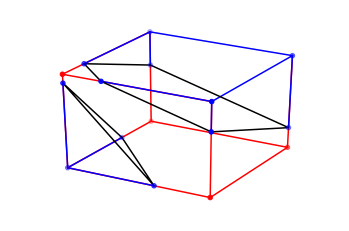

In [7]:
#
# Just the plotting code of a barmesh using matplotlib.  Nothing interesting here except the diagram
#

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
def plotbarmeshlines(ax, barmesh):
    def scatterpointscolor(points, color):
        ax.scatter([point[0]  for point in points], 
                   [point[1]  for point in points], 
                   [point[2]  for point in points], color=color)

    def drawlinecolor(point0, point1, color):
        ax.plot([point0[0], point1[0]], 
                [point0[1], point1[1]], 
                [point0[2], point1[2]], color=color)
        
    scatterpointscolor([node.point  for node in barmesh.nodes  if node.intensity <= 0], "blue")
    scatterpointscolor([node.point  for node in barmesh.nodes  if node.intensity > 0], "red")
    scatterpointscolor([bar.midpoint  for bar in barmesh.bars  if bar.midpoint is not None], "blue")
    
    for bar in barmesh.bars:
        drawlinecolor(bar.nodeback.point, bar.nodefore.point, 
                      ("blue" if (bar.nodeback.intensity <= 0 and bar.nodefore.intensity <=0) else "red"))
        if bar.nodeback.intensity <= 0 and bar.nodefore.intensity > 0:
            drawlinecolor(bar.nodeback.point, bar.midpoint, "blue")
        if bar.nodeback.intensity > 0 and bar.nodefore.intensity <= 0:
            drawlinecolor(bar.midpoint, bar.nodefore.point, "blue")
            

def plotpolyfaces(ax, polyfaces):
    def closedpolycoord(polyface, i):
        return [ p[i]  for p in polyface ] + [ polyface[0][i] ]
    for polyface in polyfaces:
        ax.plot(closedpolycoord(polyface, 0), closedpolycoord(polyface, 1), closedpolycoord(polyface, 2), "black") 
            

def intensity_func(x, y, z):
    return ((int(x)*345345 + int(y)*283823 + int(z)*23112124)%80)/40 - 1


#
# Build, cut and plot the cube
#
barmesh = BuildCubeBarmesh((0,0,0), (1,1,1))
setintensities(barmesh, intensity_func)
setcutpoints(barmesh)
polyfaces = ExtractAllCutPolyhedralFaces(barmesh)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax._axis3don = False

plotbarmeshlines(ax, barmesh)
plotpolyfaces(ax, polyfaces)

    

In [13]:
# two non-standard libraries need importing
try:
    import ipyvolume
except ModuleNotFoundError:
    print("Please pip install ipyvolume")
    
try:
    import opensimplex
except ModuleNotFoundError:
    print("Please pip install opensimplex")

In [14]:
# 
# Show simplex noise using ipyvolume (anything more than single cube in matplotlib looks bad)
#

from opensimplex import OpenSimplex
import numpy as np
import ipyvolume as ipv

xpartition = np.linspace(0, 3, 16)
ypartition = np.linspace(0, 3, 16)
zpartition = np.linspace(0, 1, 5)

ipv.clear()
ipv.figure(width=800)
simplexnoise = OpenSimplex(1)

meshpolyfaces = [ ]
for x0, x1 in zip(xpartition, xpartition[1:]):
    for y0, y1 in zip(ypartition, ypartition[1:]):
        for z0, z1 in zip(zpartition, zpartition[1:]):
            barmesh = BuildCubeBarmesh((x0, y0, z0), (x1, y1, z1))
            setintensities(barmesh, simplexnoise.noise3d)
            setcutpoints(barmesh)
            cubepolyfaces = ExtractAllCutPolyhedralFaces(barmesh)
            meshpolyfaces.extend(cubepolyfaces)

            
points, triangles = [ ], [ ]
for polyface in meshpolyfaces:
    for i in range(2, len(polyface)):
        triangles.extend([len(points), len(points)+i, len(points)+i-1])
        points.extend(polyface)
    
mesh = ipv.plot_trisurf([p[0]  for p in points], [p[1]  for p in points], [p[2]  for p in points], 
                        triangles=triangles, color='orange')
ipv.show()

## Transvoxel technology

This requires us to split voxels by a factor of 2 (eight subvoxels) and have the adjoining voxels 
have just their faces split, but for the `f=0`surface to join up properly.

All the code above works the same, once we create the transvoxels, which we create here by applying 
edges and face splits on a cubical voxel in a barmesh.  

Some diagonal voxels also need their edges split to close all the holes.

In [15]:
# 
# This splits faces of a polyhedron simultaneously.  
# It will split the square faces of a cube into four squares each (and works with any polygonal face)
#
def ExtractPolyhedralfaceBars(nodefrom, bar):
    nodeseq = [ nodefrom ]
    barseq = [ bar ]
    while True:
        nodefrom, bar = bar.GetNodeFore(bar.nodeback == nodefrom), bar.GetForeRightBL(bar.nodeback == nodefrom)
        if bar == barseq[0]:
            break
        nodeseq.append(nodefrom)
        barseq.append(bar)
        assert len(nodeseq) <= 12, [ node.point  for node in nodeseq ]
    return nodeseq, barseq

def CentreValue(vs):
    v0, v1 = min(vs), max(vs)
    return (v0+v1)/2  if v0 != v1  else v0
    
def CentrePoint(points):
    return (CentreValue([p[0]  for p in points]), 
            CentreValue([p[1]  for p in points]),
            CentreValue([p[2]  for p in points]))

def HalfSplitBarInPlace(barmesh, bar):
    nodefore = bar.nodefore
    nodeback = bar.nodeback
    barforeright = bar.barforeright
    barbackleft = bar.barbackleft
    
    # can only reach by traversing around faces
    barforeleft = ExtractPolyhedralfaceBars(bar.nodefore, bar)[1][-1] 
    barbackright = ExtractPolyhedralfaceBars(bar.nodeback, bar)[1][-1]
    assert bar == barforeleft.GetForeRightBL(barforeleft.nodefore == nodefore)
    assert bar == barbackright.GetForeRightBL(barbackright.nodefore == nodeback)
    
    nodehalf = barmesh.NewNode(CentrePoint([nodeback.point, nodefore.point]))
    halfbarfore = barmesh.NewBar(nodehalf, nodefore)
    halfbarback = bar
    halfbarback.nodefore = nodehalf
    halfbarback.SetBarFRBL(halfbarfore, barbackleft)
    halfbarfore.SetBarFRBL(barforeright, halfbarback)
    
    barforeleft.SetForeRightBL(barforeleft.nodefore == nodefore, halfbarfore)
    assert barbackright.GetForeRightBL(barbackright.nodefore == nodeback) == halfbarback


def QuarterSplitFaces(barmesh, barfacestosplit, additionalbarstosplit=[]):
    # Split the necessary edges only once each
    barstosplit = additionalbarstosplit.copy()   # don't edit the default or incoming
    for barfacetosplit in barfacestosplit:
        for bar in ExtractPolyhedralfaceBars(barfacetosplit.nodeback, barfacetosplit)[1]:
            if bar not in barstosplit:
                barstosplit.append(bar)
    for bar in barstosplit:
        HalfSplitBarInPlace(barmesh, bar)

    # make centre point and join with spokes 
    for barfacetosplit in barfacestosplit:
        polynodeseq, polybarseq = ExtractPolyhedralfaceBars(barfacetosplit.nodeback, barfacetosplit)
        nodecentre = barmesh.NewNode(CentrePoint([node.point  for node in polynodeseq]))
        barspokes = [ barmesh.NewBar(nodehalf, nodecentre)  for nodehalf in polynodeseq[1::2] ]

        for halfbarback, nodehalf, halfbarfore, barspoke, prevbarspoke  in \
                zip(polybarseq[::2], polynodeseq[1::2], polybarseq[1::2], barspokes, [barspokes[-1]]+barspokes[:-1]):
            barspoke.SetBarFRBL(prevbarspoke, halfbarfore)
            assert halfbarback.GetForeRightBL(halfbarback.nodefore == nodehalf) == halfbarfore
            halfbarback.SetForeRightBL(halfbarback.nodefore == nodehalf, barspoke)
    
    


Text(0.5, 0.92, 'programatic transvoxels')

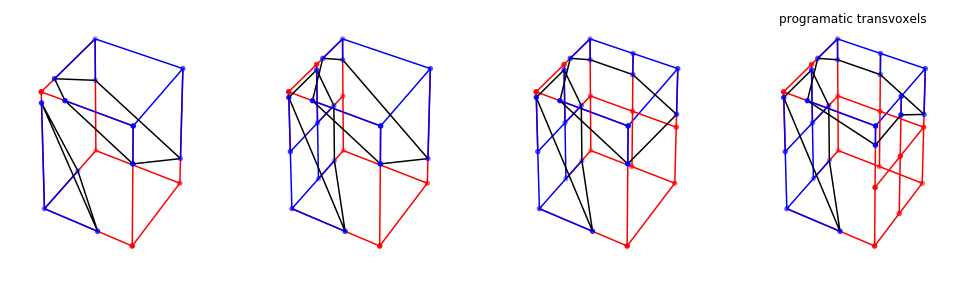

In [17]:
#
# Plot of example transvoxels.  Once you have the polyhedron in barmesh form, 
# the ExtractAllCutPolyhedralFaces() function just works no matter the complexity
#
quarterfacelist = [ [ ], [0], [0, 3], [0, 1, 3] ]

fig = plt.figure(figsize=(17,5), frameon=False)
for j, quarterfaces in enumerate(quarterfacelist):
    barmesh = BuildCubeBarmesh((0,0,0), (1,1,1))
    QuarterSplitFaces(barmesh, [ barmesh.barrightfaces[i]  for i in quarterfaces ])

    setintensities(barmesh, intensity_func)
    setcutpoints(barmesh)
    polyfaces = ExtractAllCutPolyhedralFaces(barmesh)

    ax = fig.add_subplot(1,len(quarterfacelist),j+1, projection='3d')
    ax._axis3don = False
    plotbarmeshlines(ax, barmesh)
    plotpolyfaces(ax, polyfaces)

plt.title("programatic transvoxels")

In [20]:
# 
# Demonstrate subdivisions of voxels on simplex noise manifold with transvoxels or with cracks
#

transvoxels = True

from opensimplex import OpenSimplex
import numpy as np
import ipyvolume as ipv

xpartition = list(np.linspace(0, 3, 12))
ypartition = list(np.linspace(0, 3, 12))
zpartition = list(np.linspace(0, 1, 6))

def halfvoxelsignal(x, y, z):
    return 0.5 < x < 2.5 and y < 1 and z < 0.7


def OctCubes(p0, p1):
    (x0, y0, z0) = p0
    (x1, y1, z1) = p1
    def Along(lam, v0, v1):
        return v0*(1-lam) + v1*lam
    octcubes = [ ]
    for hx in [(0, 0.5), (0.5, 1)]:
        for hy in [(0, 0.5), (0.5, 1)]:
            for hz in [(0, 0.5), (0.5, 1)]:
                octcubes.append([(Along(hx[0], x0, x1), Along(hy[0], y0, y1), Along(hz[0], z0, z1)), 
                                 (Along(hx[1], x0, x1), Along(hy[1], y0, y1), Along(hz[1], z0, z1))])
    return octcubes

def getoveredgeindexes(halfvoxelsignal, translookup, xs, ys, zs):
    indexes = [ ]
    for i, (xd, yd, zd) in enumerate(translookup):
        x, y, z = xs[xd+1], ys[yd+1], zs[zd+1]
        if x is not None and y is not None and z is not None:
            if halfvoxelsignal(x, y, z):
                indexes.append(i)
    return indexes


ipv.clear()
fig = ipv.figure(width=800)
# fig.camera_fov = 1  # should have made camera orthographic
fig.xlim = (2.5, 3)
fig.ylim = (0, 0.2)
fig.zlim = (0.5, 0.9)

simplexnoise = OpenSimplex(1)

meshpolyfacesFull = [ ]
meshpolyfacesHalf = [ ]
meshpolyfacesTrans = [ ]
meshpolyfacesDiag = [ ]

xtriples = list(zip([None]+xpartition[:-1], xpartition, xpartition[1:]))
ytriples = list(zip([None]+ypartition[:-1], ypartition, ypartition[1:]))
ztriples = list(zip([None]+zpartition[:-1], zpartition, zpartition[1:]))

for xp, x0, x1 in xtriples:
    for yp, y0, y1 in ytriples:
        for zp, z0, z1 in ztriples:
#for xp, x0, x1 in xtriples[-1:]:
#    for yp, y0, y1 in ytriples[:1]:
#        for zp, z0, z1 in ztriples[-2:]:
            p0 = (x0, y0, z0)
            p1 = (x1, y1, z1)
            dohalfvoxel = halfvoxelsignal(x0, y0, z0)
            if dohalfvoxel:
                cubes = OctCubes(p0, p1)
                meshpolyfaces = meshpolyfacesHalf
            else:
                cubes = [(p0, p1)]
                meshpolyfaces = meshpolyfacesFull

            for p0, p1 in cubes:
                barmesh = BuildCubeBarmesh(p0, p1)
                if not dohalfvoxel and transvoxels:
                    # transfacelookuptorightfaces, transedgelookuptodiagonals defined with the cube to 
                    # relate face or edge to adjacent or diagonal cell
                    rightfaceindexes = getoveredgeindexes(halfvoxelsignal, transfacelookuptorightfaces, 
                                                          [xp, x0, x1], [yp, y0, y1], [zp, z0, z1])
                    diagedgeindexes  = getoveredgeindexes(halfvoxelsignal, transedgelookuptodiagonals, 
                                                          [xp, x0, x1], [yp, y0, y1], [zp, z0, z1])
                    #print(rightfaceindexes)
                    if rightfaceindexes or diagedgeindexes:
                        barfacestosplit = [ barmesh.barrightfaces[i]  for i in rightfaceindexes ]
                        additionalbarstosplit = [ barmesh.bars[i]  for i in diagedgeindexes ]
                        QuarterSplitFaces(barmesh, barfacestosplit, additionalbarstosplit)
                        meshpolyfaces = meshpolyfacesTrans if barfacestosplit else meshpolyfacesDiag
                        
                setintensities(barmesh, simplexnoise.noise3d)
                setcutpoints(barmesh)
                cubepolyfaces = ExtractAllCutPolyhedralFaces(barmesh)
                meshpolyfaces.extend(cubepolyfaces)

            
for k, meshpolyfaces in enumerate([meshpolyfacesFull, meshpolyfacesHalf, meshpolyfacesTrans, meshpolyfacesDiag]):
    points, triangles = [ ], [ ]
    for polyface in meshpolyfaces:
        for i in range(2, len(polyface)):
            triangles.extend([len(points), len(points)+i, len(points)+i-1])
            points.extend(polyface)
    if triangles:
        mesh = ipv.plot_trisurf([p[0]  for p in points], [p[1]  for p in points], [p[2]  for p in points], 
                                triangles=triangles, color=['orange', 'red', 'green', 'cyan'][k])
ipv.show()
